# Baseline (черновик)

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/dataset_for_ml.csv')

In [5]:
cat_features = df.nunique()[3:].index.to_list()
num_features = df.nunique()[:2].index.to_list()

In [6]:
# Разделение на признаки и целевую переменную
X = df.drop('target', axis=1)
y = df['target']

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Стратификация для сохранения баланса
)

# Препроцессинг
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

# Создание пайплайна с обработкой дисбаланса
model = make_pipeline(
    preprocessor,
    SMOTE(sampling_strategy=0.3, random_state=42),  # Увеличиваем миноритарный класс до 30%
    LogisticRegression(
        class_weight='balanced',
        solver='liblinear',
        random_state=42,
        max_iter=1000
    )
)

# Кросс-валидация
cv_scores = cross_val_score(
    model, 
    X_train, 
    y_train, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Cross-Validation ROC-AUC: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

# Обучение модели
model.fit(X_train, y_train)

# Предсказания на тесте
y_pred_proba = model.predict_proba(X_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nTest ROC-AUC: {test_roc_auc:.3f}")

# Дополнительные метрики
print("\nClassification Report:")
print(classification_report(y_test, model.predict(X_test)))

# Важность признаков (для числовых)
if len(num_features) > 0:
    feature_importance = pd.DataFrame({
        'feature': num_features,
        'importance': model.named_steps['logisticregression'].coef_[0][:len(num_features)]
    })
    print("\nFeature Importance (numeric):")
    print(feature_importance.sort_values('importance', ascending=False))

Cross-Validation ROC-AUC: 0.795 ± 0.001

Test ROC-AUC: 0.796

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.78      0.87    329947
           1       0.13      0.67      0.22     16425

    accuracy                           0.77    346372
   macro avg       0.55      0.72      0.54    346372
weighted avg       0.94      0.77      0.84    346372


Feature Importance (numeric):
                   feature  importance
0  event_categories_number    0.733973
1        hit_number_median    0.186292


<Figure size 1000x800 with 0 Axes>

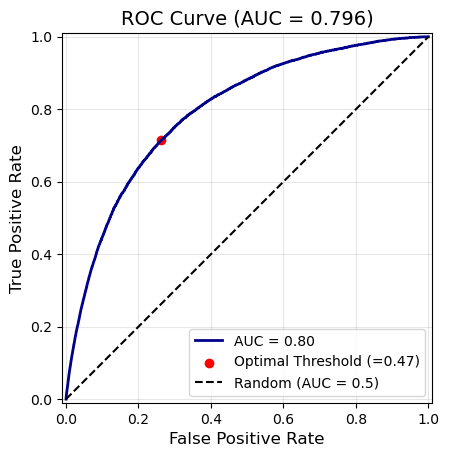

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

# Получаем предсказанные вероятности
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Рассчитываем метрики
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Создаем фигуру
plt.figure(figsize=(10, 8))

# ROC-кривая
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot(linestyle='-', linewidth=2, color='darkblue')

# Добавляем важные точки
optimal_idx = np.argmax(tpr - fpr)  # Оптимальный порог по Youden's J
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], 
            color='red', label=f'Optimal Threshold (={thresholds[optimal_idx]:.2f})')

# Добавляем диагональ
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')

# Настраиваем отображение
plt.title(f'ROC Curve (AUC = {roc_auc:.3f})', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])

# Добавляем интерактивность (для Jupyter)
plt.gcf().set_facecolor('white')
plt.show()

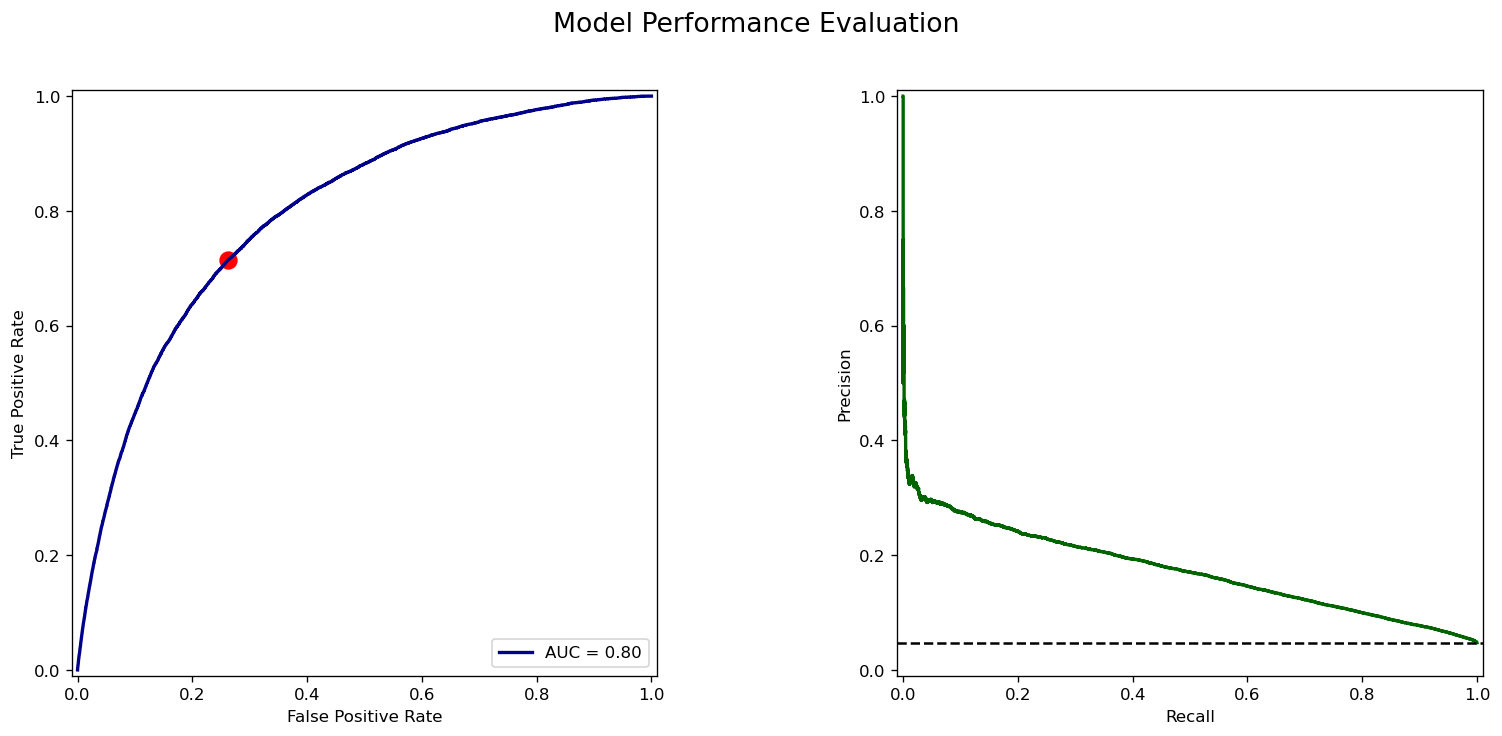

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
import numpy as np

# Убедимся, что используем правильный бэкэнд для matplotlib
plt.switch_backend('Agg')  # Или 'TkAgg', 'Qt5Agg' в зависимости от среды

# Получаем предсказания
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Создаем фигуру перед вычислениями
plt.figure(figsize=(14, 6), dpi=100)  # Увеличиваем DPI для четкости

# --- ROC-AUC ---
plt.subplot(1, 2, 1)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)  # Явно вычисляем AUC

# Отображаем кривую
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot(ax=plt.gca(), linewidth=2, color='darkblue')

# Добавляем оптимальную точку
optimal_idx = np.argmax(tpr - fpr)
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], 
            color='red', s=100, label=f'Optimal Threshold = {thresholds[optimal_idx]:.2f}')

# --- Precision-Recall ---
plt.subplot(1, 2, 2)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Отображаем кривую
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot(ax=plt.gca(), linewidth=2, color='darkgreen')

# Добавляем базовую линию
baseline = len(y_test[y_test==1]) / len(y_test)
plt.axhline(y=baseline, color='k', linestyle='--', 
            label=f'Baseline = {baseline:.3f}')

# Общие настройки
plt.suptitle('Model Performance Evaluation', y=1.02, fontsize=16)
plt.tight_layout()

# Сохраняем в файл для гарантии
plt.savefig('roc_pr_curves.png', bbox_inches='tight', dpi=120)
plt.close()  # Закрываем фигуру

# Открываем сохраненное изображение (для Jupyter)
from IPython.display import Image
Image(filename='roc_pr_curves.png')